In [29]:

# Default locations if parameter not passed
benchmark_data_path = "pkl/big-matrix-sorgan.pkl"


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])


rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'node_count', 'biggest_matrix', 'hosts', 'full_output',
       'simu_rr', 'time'],
      dtype='object')

name  node_count  biggest_matrix  \
0             big-matrix         4.0             NaN   
1  simulator-matrix-feed         NaN             4.0   
2  simulator-matrix-feed         NaN             4.0   

                                             hosts  \
0  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
1  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
2  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   

                                         full_output  simu_rr       time  
0                                                NaN      NaN  55.808040  
1  Time Simulation (microseconds) : 9351 \nDistan...      2.0   0.643607  
2  Time Simulation (microseconds) : 9536 \nDistan...      3.0   0.822690

name  node_count  biggest_matrix  \
0             big-matrix         4.0             NaN   
1  simulator-matrix-feed         NaN             4.0   
2  simulator-matrix-feed         NaN             4.0   

                                             hosts  \
0  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
1  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   
2  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4   

                                         full_output  simu_rr       time  
0                                                NaN      NaN  55.808040  
1  Time Simulation (microseconds) : 9351 \nDistan...      2.0   0.643607  
2  Time Simulation (microseconds) : 9536 \nDistan...      3.0   0.822690

In [31]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [32]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [33]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

max_node_count = 0

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        if "node_count" in row:
            node_count = row["node_count"]
            if node_count > max_node_count:
                max_node_count = node_count
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()

max_node_count = int(max_node_count)
print(f"Max node count: {max_node_count}")

Benchmark: big-matrix - Runs: 1
--- Row 0 ---
name: big-matrix
node_count: 4.0
biggest_matrix: nan
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
full_output: nan
simu_rr: nan
time: 55.80804026708938

Benchmark: simulator-matrix-feed - Runs: 1
--- Row 1 ---
name: simulator-matrix-feed
node_count: nan
biggest_matrix: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
full_output: Time Simulation (microseconds) : 9351 
Distance : 0.286624


simu_rr: 2.0
time: 0.6436067139729857

--- Row 2 ---
name: simulator-matrix-feed
node_count: nan
biggest_matrix: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
full_output: Time Simulation (microseconds) : 9536 
Distance : 0


simu_rr: 3.0
time: 0.8226896610576659

Max node count: 4


# Experiment 1
x-axis: SIM_RR
y_axis: distance 

In [34]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

In [35]:
df_dist = df[df["name"] == "simulator-matrix-feed"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["simu_rr", "distance"]]

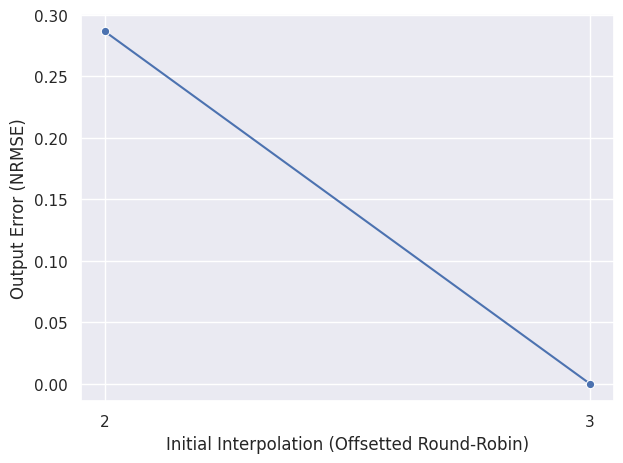

In [36]:
plt.figure()
sns.lineplot(
  data=df_dist,
  x="simu_rr",
  y="distance",
  marker="o",
  errorbar="ci",
)

plt.xlabel("Initial Interpolation (Offsetted Round-Robin)")
plt.ylabel("Output Error (NRMSE)")
#plt.title(f"Simulation Distance per Simulation RR using Matrix trace for {max_node_count-1} workers")
plt.grid(True)
plt.xticks(sorted(df_dist["simu_rr"].unique()))
plt.tight_layout()
plt.savefig("figs/simulator-matrix-feed-distance.pdf")
plt.show()